In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from glob import glob
import numpy as np
from datetime import datetime
from collections import defaultdict, OrderedDict

import term_hiearchy
import re
import tqdm.notebook

sns.set_style('whitegrid')
sns.set_palette('colorblind')

# Descriptive Statistics


Describe the terms-used (grouped into categories) in incels.is inceldom threads in the 2021-04-15 scrape. 
These have been generated by scraping the inceldom portion of the forum (`scripts/scrape_incels.py`) then generating a glossary from grounded qualitative analysis of a random subset of threads.
This glossary was then used to generate regular expressions which in turn were used to query the scraped forum text (`scripts/generate_datasets_hierarchy.py`).
Finally, these hits were processed to remove false positives and then filtered according to a term hierarchy to resolve overlapping hits `notebooks/0.query_processing.ipynb`.

This generated `2021_04_15_inceldom_discussion_scrape/hierarchy_query_data_PROCESSED.tsv`

First we need to parse the data required.

In [2]:
# Number derived from total users listed at time of scraping 
# (note there is a 5 user discrepancy between this user and the total number of users based on posting activity)
TOTAL_USERS = 8130

In [3]:
query_data = pd.read_csv('../2021_04_15_inceldom_discussion_scrape/hierarchy_query_data_PROCESSED.tsv.gz', sep='\t', lineterminator='\n')
post_data = pd.read_csv('../2021_04_15_inceldom_discussion_scrape/hierarchy_post_data.tsv.gz', sep='\t', lineterminator='\n')

Calculate numbers used in the paper:

In [4]:
print("Number of posts", post_data.shape[0])
first_post = pd.to_datetime(post_data['post_time'].min(), unit='s')
last_post = pd.to_datetime(post_data['post_time'].max(), unit='s')
print(f"First post {first_post} to last post {last_post}")
print(f"Across {(last_post.to_period('M') - first_post.to_period('M')).n + 1} Months")

Number of posts 3686110
First post 2017-11-08 02:49:06 to last post 2021-04-16 01:16:38
Across 42 Months


Then apply our term categories and super-categories

In [5]:
query_data.loc[query_data['query_term'].str.lower().isin(['femoid', 'foid']), 'query_category'] = "Femoid/Foid"
query_data.loc[query_data['query_category'] == "Homophobic Misogyny", 'query_category'] = 'Other Misogyny'
query_data.loc[(query_data['query_category'] == "Girl/Female") & (query_data['query_term'] == "girl"), 'query_category'] = 'Girl'
query_data.loc[(query_data['query_category'] == "Girl/Female") & (query_data['query_term'] == "female"), 'query_category'] = 'Female'

total_misogyny = query_data[query_data['query_category'].isin([
    "Racist Misogyny",
    "Stacy/Becky",
    "Female",
    "Femoid/Foid",
    "Girl",
    "Other Misogyny"])]
total_misogyny['query_category'] = 'Total Misogyny'

table1_query_data = pd.concat([query_data, total_misogyny])

/tmp/ipykernel_77624/437975439.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_misogyny['query_category'] = 'Total Misogyny'


## Table1

Summary for each term category with:

- Number of uses
- Posts with term (%)
- Threads with term in title (%)
- Threads with term in first post (%)
- Threads with term anywhere (%)
- Participants using term (%)

In [6]:
# additional data needed for categorisation
table1_query_data['thread_post_postion'] = table1_query_data['thread_url'] + table1_query_data['post_position']

total_posts = post_data.shape[0] 
total_threads = post_data['thread_url'].nunique() 
total_users = post_data['username'].nunique()

table1 = pd.DataFrame()

table1['Number of uses'] = table1_query_data['query_category'].value_counts()
table1['Posts with term (%)'] = table1_query_data.groupby('query_category')['thread_post_postion'].nunique() / post_data.shape[0] * 100
table1['Threads with term in title (%)'] = table1_query_data[table1_query_data['post_position'] == 'title'].groupby('query_category')['thread_url'].nunique() / total_threads * 100
table1['Threads with term in first post (%)']  = table1_query_data[table1_query_data['post_position'] == '0'].groupby('query_category')['thread_url'].nunique() / total_threads * 100
table1['Threads with term anywhere (%)']  = table1_query_data.groupby('query_category')['thread_url'].nunique() / total_threads * 100
table1['Participants using term (%)'] = table1_query_data.groupby('query_category')['username'].nunique() / total_users * 100

table1 = table1.rename(index={'Women/Lady': 'Neutral Terms', 'Femoid/Foid': 'Foid'})
table1 = table1.loc[['Neutral Terms',
                     'Total Misogyny',
                     'Racist Misogyny',
                     'Stacy/Becky',
                     'Girl',
                     'Female',
                     'Foid',
                     'Other Misogyny'], :]
    
table1.to_csv('../results/table1_usage_counts.tsv', sep='\t')

In [7]:
table1

,Number of uses,Posts with term (%),Threads with term in title (%),Threads with term in first post (%),Threads with term anywhere (%),Participants using term (%)
Neutral Terms,402045,7.303607,7.944642,20.764362,57.796654,67.712177
Total Misogyny,960487,17.344111,17.717517,39.429758,82.341805,81.242312
Racist Misogyny,33336,0.755946,0.768022,1.532258,8.650187,29.963100
Stacy/Becky,41047,0.913999,0.907490,3.174954,13.625607,38.499385
Girl,200224,4.076303,4.116522,14.370910,41.855622,63.247232
Female,115019,2.438451,2.483292,7.906146,31.707256,48.499385
Foid,254962,5.421623,5.203870,12.011940,50.100026,49.963100
Other Misogyny,315899,6.520994,4.833427,15.968168,56.570469,64.969250


Calculate numbers used in paper (relative posting x of neutral vs total misogyny)

In [8]:
neut_vs_misogyny = table1.loc['Total Misogyny', 'Number of uses'] / table1.loc['Neutral Terms', 'Number of uses']
print("Total Misogyny used / Neutral Terms used:", neut_vs_misogyny)

user_with_misogyny = total_misogyny.loc[total_misogyny['query_category'] == 'Total Misogyny', 'username'].value_counts()
user_with_neut = query_data.loc[query_data['query_category'] == 'Women/Lady', 'username'].value_counts()


Total Misogyny used / Neutral Terms used: 2.389003718489224


In [9]:
81.2 / 67.7

1.1994091580502215

## Table 2 

Use of misogynistic terms by number of user posts

In [10]:
usage_rate = total_misogyny['username'].value_counts().reset_index(name='Total Misogyny Term Count')
usage_rate = usage_rate['Total Misogyny Term Count'].value_counts().reset_index(name='Number of Users').rename(columns={'index': 'Count of Total Misogynistic Terms'})
usage_rate = usage_rate.sort_values(['Count of Total Misogynistic Terms', 'Number of Users'])
usage_rate['Count of Total Misogynistic Terms Bins'] = pd.cut(usage_rate['Count of Total Misogynistic Terms'], [0,1,5,10,50,100,250,500,1000,2000,100000])

usage_rate = usage_rate.groupby('Count of Total Misogynistic Terms Bins')['Number of Users'].sum().reset_index()
usage_rate['Misogynistic Terms Usage Bins'] = usage_rate['Count of Total Misogynistic Terms Bins'].astype(str)

clean_usage_rate = usage_rate[['Misogynistic Terms Usage Bins', 'Number of Users']]#.to_csv('total_misogyny_usage_user_counts.tsv', sep='\t')
clean_usage_rate['Misogynistic Terms Usage Bins'] = clean_usage_rate['Misogynistic Terms Usage Bins'].replace({'(0, 1]': '1',
                          '(1, 5]': '2-5',
                          '(5, 10]': '6-10',
                          '(10, 50]': '11-50',
                          '(50, 100]': '51-100',
                          '(100, 250]': '101-250',
                          '(250, 500]': '251-500',
                          '(500, 1000]': '501-1000',
                          '(1000, 2000]': '1001-2000',
                          '(2000, 100000]': '>2000'})
no_posts = pd.DataFrame({'Misogynistic Terms Usage Bins': ['0'], 'Number of Users': [TOTAL_USERS - clean_usage_rate['Number of Users'].sum()]})
clean_usage_rate = pd.concat([no_posts, clean_usage_rate])
clean_usage_rate['Percentage of Users'] = clean_usage_rate['Number of Users'] / clean_usage_rate['Number of Users'].sum() * 100
total = pd.DataFrame({'Misogynistic Terms Usage Bins': ['Total'], 'Number of Users': [clean_usage_rate['Number of Users'].sum()], 'Percentage of Users': [100]})
clean_usage_rate = pd.concat([clean_usage_rate, total])

clean_usage_rate = clean_usage_rate.rename(columns={'Misogynistic Terms Usage Bins': 'Number of Posts with at Least One Misogynistic Term', 
                                                    'Number of Users': 'Number of Participants', 
                                                    'Percentage of Users': 'Percent of Participants'})
clean_usage_rate.to_csv('../results/table2_total_misogyny_usage_user_counts.tsv', sep='\t', index=False)

/tmp/ipykernel_77624/895681013.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_usage_rate['Misogynistic Terms Usage Bins'] = clean_usage_rate['Misogynistic Terms Usage Bins'].replace({'(0, 1]': '1',


Calculate numbers used in manuscript text:

In [11]:
all_threads = set(post_data['thread_url'].unique())
misogynistic_threads = set(total_misogyny.loc[total_misogyny['query_category'] == 'Total Misogyny', 'thread_url'].unique())
print(f"Threads containing total misogyny: {len(misogynistic_threads) / len(all_threads) * 100}%")

all_users = set(post_data['username'].unique())
misogynistic_users = set(total_misogyny.loc[total_misogyny['query_category'] == 'Total Misogyny', 'username'].unique())
print(f"Users posting a total misogyny term: {len(misogynistic_users) / len(all_users) * 100}%")

non_misogynistic_users = set(post_data['username'].unique()) - set(total_misogyny['username'].unique())
print(f"Non misogynism using posters average number of posts", post_data.loc[post_data['username'].isin(non_misogynistic_users), 'username'].value_counts().mean())

Threads containing total misogyny: 82.34180450463526%
Users posting a total misogyny term: 81.24231242312423%
Non misogynism using posters average number of posts 3.7958115183246073


## Figure 1

Percentage of Participants (grouped by total posts) that use Misogynistic Terms

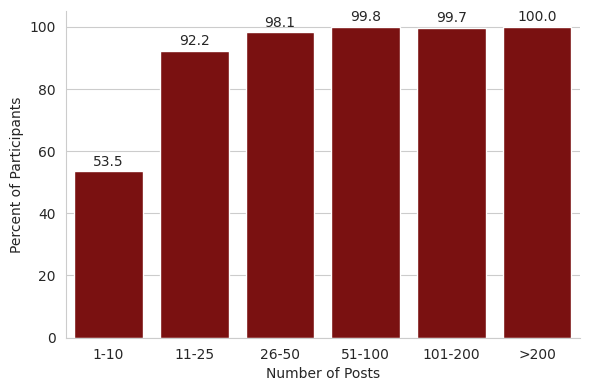

In [12]:
user_posts = post_data['username'].value_counts().reset_index(name='Number of Posts').rename(columns={'index': 'username'})
user_posts['user_category'] = pd.cut(user_posts['Number of Posts'], bins=[0, 10, 25, 50, 100,200, 1000000])

binned_users = {'Number of Posts': [], 'Percent of Participants': [], 'Number of Users in Category': [], 'Number of Users in Category Using Any Misogynistic Term': []}
for user_category in user_posts['user_category'].dropna().sort_values().unique():
    usernames_in_category = user_posts.loc[user_posts['user_category'] == user_category, 'username'].values
    
    queries_by_usernames_in_category = total_misogyny.loc[total_misogyny['username'].isin(usernames_in_category), 'username'].unique()
    
    perc_of_users_in_category_using_terms = len(queries_by_usernames_in_category) / len(usernames_in_category) * 100
    
    binned_users['Number of Users in Category'].append(len(usernames_in_category))
    binned_users['Number of Users in Category Using Any Misogynistic Term'].append(len(queries_by_usernames_in_category))
    binned_users['Number of Posts'].append(user_category)
    binned_users['Percent of Participants'].append(perc_of_users_in_category_using_terms)
    
binned_users = pd.DataFrame(binned_users)
binned_users['Number of Posts'] = binned_users['Number of Posts'].astype(str).replace({'(0, 10]': '1-10',
                                                                '(10, 25]': '11-25',
                                                                 '(25, 50]': '26-50',
                                                                 '(50, 100]': '51-100',
                                                                 '(100, 200]': '101-200',
                                                                 '(200, 1000000]': '>200'})


g = sns.catplot(data = binned_users, y='Percent of Participants', x='Number of Posts', kind='bar', color='darkred', height=4, aspect=3/2)

for container in g.ax.containers:
    g.ax.bar_label(container, fmt='%.1f', padding=2)

plt.savefig("../results/figure_1_participants_using_terms_by_total_posts", dpi=300, bbox_inches='tight')

## Figure 3

Percent of Participants Using Misogynistic Terms, By Number of Posts

/tmp/ipykernel_77624/3158781019.py:26: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  binned_users['Users with _ up to _ posts'] = binned_users['Users with _ up to _ posts'].astype(str).str.replace('(', '').str.replace(']', '').str.replace(', ', ' - ').str.replace('1000 - 1000000', '>1000')


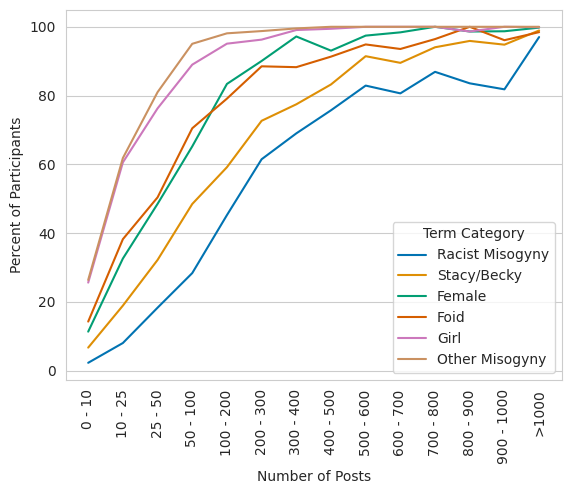

In [13]:
post_data_counts = post_data['username'].value_counts().reset_index(name='number_of_posts').rename(columns={'index': 'username'})
post_data_counts['user_category'] = pd.cut(post_data_counts['number_of_posts'], bins=[0, 10, 25, 50, 100,200,300,400,500,600,700,800,900,1000, 1000000])
used_categories = ['Racist Misogyny', 'Stacy/Becky', 'Female', 'Foid', 'Girl', 'Other Misogyny']
fig3_data = table1_query_data
fig3_data['query_category'] = fig3_data['query_category'].replace({'Femoid/Foid': 'Foid'})

binned_users = {'Users with _ up to _ posts': [], '% Using Misogynistic Terms': [], 'Number of Users in Category': [], 'Number of Users in Category Using Any Misogynistic Term': [], 'Term Category': []}
for user_category in post_data_counts['user_category'].dropna().sort_values().unique():
    
    usernames_in_category = post_data_counts.loc[post_data_counts['user_category'] == user_category, 'username'].values
    
    for term_category in used_categories:
        term_category_df = table1_query_data.loc[table1_query_data['query_category'] == term_category]
        
        queries_by_usernames_in_category = term_category_df.loc[term_category_df['username'].isin(usernames_in_category), 'username'].unique()

        perc_of_users_in_category_using_terms = len(queries_by_usernames_in_category) / len(usernames_in_category) * 100

        binned_users['Number of Users in Category'].append(len(usernames_in_category))
        binned_users['Number of Users in Category Using Any Misogynistic Term'].append(len(queries_by_usernames_in_category))
        binned_users['Users with _ up to _ posts'].append(user_category)
        binned_users['% Using Misogynistic Terms'].append(perc_of_users_in_category_using_terms)
        binned_users['Term Category'].append(term_category)
    
binned_users = pd.DataFrame(binned_users)
binned_users['Users with _ up to _ posts'] = binned_users['Users with _ up to _ posts'].astype(str).str.replace('(', '').str.replace(']', '').str.replace(', ', ' - ').str.replace('1000 - 1000000', '>1000')

ax = sns.lineplot(data = binned_users, sort= False, hue_order=used_categories,  y='% Using Misogynistic Terms', x='Users with _ up to _ posts', hue='Term Category')# kind='bar', palette='viridis_r')
plt.xticks(rotation=90)
plt.ylabel('Percent of Participants')
plt.xlabel('Number of Posts')
ax.xaxis.grid(False)
plt.savefig("../results/figure_3_user_bin_plot_lines_non_profile.png", dpi=300, bbox_inches='tight')
#binned_users.to_csv('binned_user_data_all_categories_non_profile.tsv', sep='\t', index=False)

## Appendix B

List of Misogynistic Terms by Category

In [14]:
import term_hiearchy 

appendix_b_term_list = {'Term Category': [], 'Term': []}

for term_category, terms in term_hiearchy.hierarchy.items():
    for term in terms:
        appendix_b_term_list['Term Category'].append(term_category)
        appendix_b_term_list['Term'].append(term)
        
appendix_b_term_list = pd.DataFrame(appendix_b_term_list)
appendix_b_term_list = appendix_b_term_list[~appendix_b_term_list['Term Category'].isin(['Homophobic Misogyny', 'Transphobic'])]
appendix_b_term_list['Term Category'] = appendix_b_term_list['Term Category'].replace({'Racist Misogyny': 'Racist Misogyny',
                                               'Racist Misogyny (if followed by other term)': 'Racist Misogyny (if followed by other term)',
                                               'Women/Lady': 'Neutral Terms',
                                               'Girl/Female': 'Girl',
                                                'Other Misogyny': 'Other Misogyny'})

appendix_b_term_list.loc[appendix_b_term_list['Term Category'] == "Homophobic Misogyny", 'Term Category'] = 'Other Misogyny'
appendix_b_term_list.loc[appendix_b_term_list['Term'] == 'female', 'Term Category'] = 'Female' 
appendix_b_term_list.loc[appendix_b_term_list['Term'] == 'foid', 'Term Category'] = 'Foid' 
appendix_b_term_list.loc[appendix_b_term_list['Term'] == 'femoid', 'Term Category'] = 'Foid' 

# exclude LGBT related terms and consistently name in line with manuscript
appendix_b_term_list = appendix_b_term_list.groupby('Term Category').agg(list).loc[['Racist Misogyny', 'Racist Misogyny (if followed by other term)',
                                                             'Stacy/Becky', 'Girl', 'Female', 'Foid', 'Other Misogyny',
                                                            'Neutral Terms']].reset_index()
appendix_b_term_list = appendix_b_term_list.rename(columns={"Term Category": 'Misogynistic Term Category', 'Term': 'Misogynistic Term'})
appendix_b_term_list.to_csv('../results/appendix/Appendix_B_terms_by_category.csv', sep='\t', index=False)

## Appendix C

In [15]:
misogyny_terms = ['whore', 'hole', 'foid', 'femoid',
       'bitch', 'cunt', 'toilet', 'pussy', 'noodle', 'slut', 'mommy',
       'gold digger', 'roastie', 'landwhale', 'feminazi',
       'JB', 'escort', 'stacy',
       'slit', 'becky', 'bird', 'twat', 'skank',
       'dyke', 'prostitute', 'gash', 'cum dumpster', 
       'bimbo', 'cum receptacle', 'thot', 'plain jane',
       'femcel', 'jailbait', 'milf', 'karen', 'axe wound',
       'sloot',
       'shit cunt', 'hog', 'HQNP', 'puta', 'ho', 'warpig', 'BBV',
       'fat ugly woman', 'lesbo', 'fat cow',
       'gutterwhore', 'cock tease', 'butterface',
       'shemale', 'roast beef whores', 'ditz',
       'hatchet wound', 'lez', 'gookette', 'milk truck',
       'big black vagina', 'sperm receptacle', 'scag', 
       'yellow cab', 'mammy', 'bim', 'JAP', 'jewish american princess',
       'butterbody', 'muffdiver', 'milk factory']

query_data[query_data['query_term'].isin(misogyny_terms)]['query_term'].value_counts().nlargest(25).to_csv('../results/appendix/Appendix_C_top25_misogyny_terms.csv', index=False, sep='\t')
